# Check findings folder for better understanding

# 📚 Import Libraries

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import cm
import os
import random
from PIL import Image
from matplotlib import cm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from IPython.core.display import HTML
from tensorflow.keras.optimizers import Adamax, Adam, Adadelta
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , classification_report, precision_score, recall_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, BatchNormalization, Dense, Dropout, Flatten, Input, Concatenate, Reshape


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2024-02-23 16:05:43.517769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 16:05:43.517877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 16:05:43.653320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.0
Found GPU at: /device:GPU:0


In [2]:

# Define custom CSS directly in Python variable
custom_css = """
<style>
  :root {
    --header1_color: #204709;
    --header2_color: #42841F;
    --header3_color: #6EAF4B;
    --keyword_color: #cc241d; /* import */
    --string_color: #79740e;
    --number_color: #b16286;
    --def_color: #689d6a; /* class name */
    --property_color: #458588; /* python properties */
    --builtin_color: #689d6a;
    --comment_color: #9f9f9f;
    --comment_color_2: #458588; /* equals sign */
    --operator_color: #a221f2;
    --font_color: #3c3836; /* general font */
    --variable2_color: #b16286; /*self keyworda */
    --box_color: #e0ffff; /* light cyan */
  }
  /* Add the following style for headers with background color */
  h1,
  .h1 {
    font-family: "Trebuchet MS", sans-serif;
    font-size: 2em !important;
    letter-spacing: 1px;
    color: var(--header1_color);
    border-bottom: 3px solid var(--header1_color);
    background-color: #ff0000; /* red */
    padding: 0.5em;
    color: #ffffff; /* white */
    text-align: center;
  }

  h2,
  .h2 {
    font-family: "Trebuchet MS";
    font-size: 1.7em !important;
    color: var(--header2_color);
    background-color: #ff0000; /* red */
    padding: 0.5em;
    color: #ffffff; /* white */
  }

  h3,
  .h3 {
    font-family: "Trebuchet MS";
    font-size: 1.4em !important;
    color: var(--header3_color);
    background-color: #ff0000; /* red */
    padding: 0.5em;
    color: #ffffff; /* white */
  }

  /* Rest of your existing styles... */

  body[data-jp-theme-light="true"] .jp-Notebook .CodeMirror.cm-s-jupyter {
    background-color: var(--box_color) !important;
  }

  div.input_area {
    background-color: var(--box_color) !important;
  }
</style>
"""
# Apply custom CSS
HTML(custom_css)

# 📖 Read Dataset

In [3]:
# Path to the folder containing images
test_folder = "test_images" # Assuming test images here
folder_path = "images" # Asumming train images here

# Load CSV file containing image labels
labels = pd.read_csv('Ground_Label.csv') # Labels with table data like Age, Gender, Position of the Patient

# 📂 Load Dataset

In [4]:
def preprocess(data, folder, num_of_examples, balance = 0.5):
    
    # Replace 'No Finding' with 0 and everything else with 1 in 'Finding Labels' column
    data['Finding Labels'] = np.array([0 if value == 'No Finding' else 1 for value in data['Finding Labels']])
    
#     THese test data , so imabalance is allowed here
    if folder == test_folder:
        data = data[:num_of_examples]
    
#     Training should have no imbalance in the data
    else:
        examples_num = int(0.5 * num_of_examples) 

        data = pd.concat([data[data['Finding Labels'] == 0].sample(examples_num), 
                          data[data['Finding Labels'] == 1].sample(num_of_examples - examples_num)],axis = 0)
    
    # Update the 'Image Index' column to contain the full path of each image file
    data['Image Index'] = data['Image Index'].apply(lambda x: os.path.join(folder, x))
    data.drop(['Patient ID','Patient Gender', 'View Position', 'Patient Age'], inplace = True, axis = 1)    
    data.reset_index(drop=True, inplace=True)
    
    return data


In [5]:
# Filter rows in train DataFrame to keep only those with corresponding image files
test = labels[labels['Image Index'].isin(os.listdir(test_folder))]

# Call the function to preprocess labels
test = preprocess(test,test_folder,1000)
test

/tmp/ipykernel_27/3792853981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Finding Labels'] = np.array([0 if value == 'No Finding' else 1 for value in data['Finding Labels']])
/tmp/ipykernel_27/3792853981.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Image Index'] = data['Image Index'].apply(lambda x: os.path.join(folder, x))
/tmp/ipykernel_27/3792853981.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

,Image Index,Finding Labels
0,/kaggle/input/project-fun/images_001/images/00...,1
1,/kaggle/input/project-fun/images_001/images/00...,1
2,/kaggle/input/project-fun/images_001/images/00...,1
3,/kaggle/input/project-fun/images_001/images/00...,0
4,/kaggle/input/project-fun/images_001/images/00...,1
...,...,...
995,/kaggle/input/project-fun/images_001/images/00...,1
996,/kaggle/input/project-fun/images_001/images/00...,0
997,/kaggle/input/project-fun/images_001/images/00...,1
998,/kaggle/input/project-fun/images_001/images/00...,0


In [6]:
# Filter rows in train DataFrame to keep only those with corresponding image files
train = labels[labels['Image Index'].isin(os.listdir(folder_path))]

# Call the function to preprocess labels
train = preprocess(train,folder_path, 5000)
train

/tmp/ipykernel_27/3792853981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Finding Labels'] = np.array([0 if value == 'No Finding' else 1 for value in data['Finding Labels']])


,Image Index,Finding Labels
0,/kaggle/input/fun-project-2/images/images/0000...,0
1,/kaggle/input/fun-project-2/images/images/0000...,0
2,/kaggle/input/fun-project-2/images/images/0000...,0
3,/kaggle/input/fun-project-2/images/images/0000...,0
4,/kaggle/input/fun-project-2/images/images/0000...,0
...,...,...
4995,/kaggle/input/fun-project-2/images/images/0000...,1
4996,/kaggle/input/fun-project-2/images/images/0000...,1
4997,/kaggle/input/fun-project-2/images/images/0000...,1
4998,/kaggle/input/fun-project-2/images/images/0000...,1


# 📊 Plot Data Balance on graph

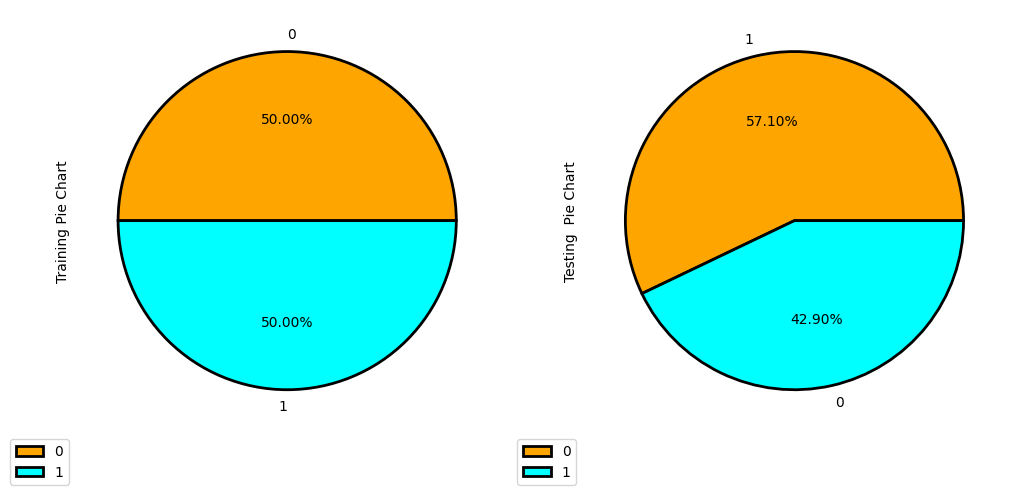

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = ["orange", "cyan"]
wp = {'linewidth': 2, 'edgecolor': "black"}
labels = train['Finding Labels'].unique()


# Plot pie chart
train['Finding Labels'].value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], colors=colors, wedgeprops=wp)
ax[0].set_ylabel("Training Pie Chart")
ax[0].legend(labels, loc="upper right", bbox_to_anchor=(0, 0, 0, 0))


# Plot pie chart
test['Finding Labels'].value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], colors=colors, wedgeprops=wp)
ax[1].set_ylabel("Testing  Pie Chart")
ax[1].legend(labels, loc="upper right", bbox_to_anchor=(0, 0, 0, 0))

plt.show()

*WE are going to use the balanced data is train and imbalanced to test the model*

# Plot images

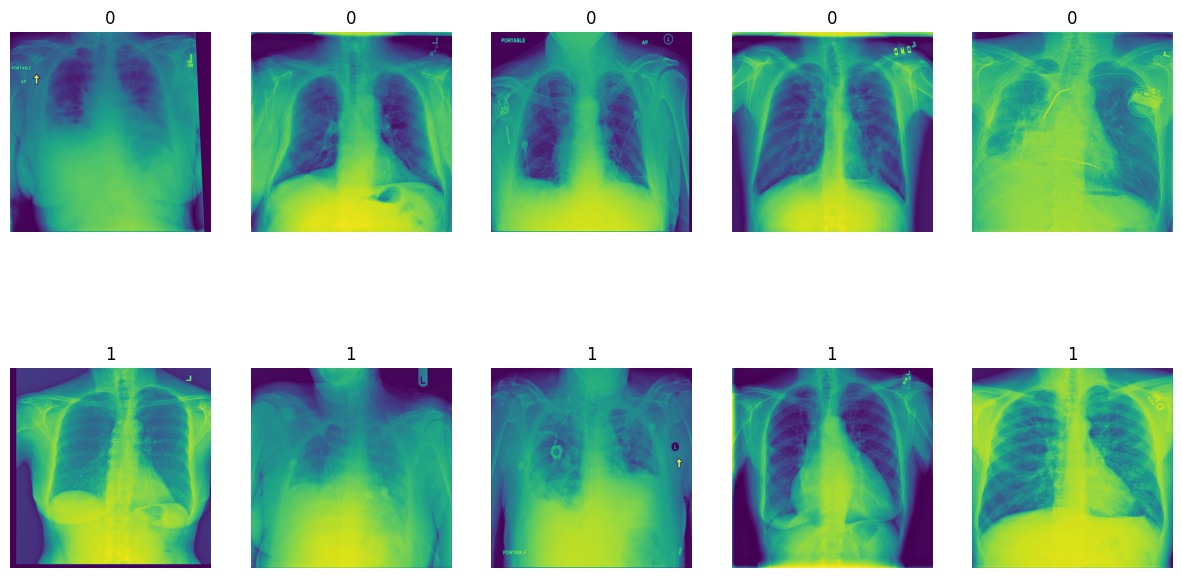

In [8]:
# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Select 5 images from '0' side
label_0_images = test[test['Finding Labels'] == 0].sample(5)

# Select 5 images from '1' side
label_1_images = test[test['Finding Labels'] == 1].sample(5)

# Plot images for label '0'
for i, image_file in enumerate(label_0_images['Image Index']):
    image_path = image_file  # Adjust the path to your images
    image = Image.open(image_path)
    axes[0, i].imshow(image)
    axes[0, i].set_title('0')
    axes[0, i].axis('off')

# Plot images for label '1'
for i, image_file in enumerate(label_1_images['Image Index']):
    image_path = image_file  # Adjust the path to your images
    image = Image.open(image_path)
    axes[1, i].imshow(image)
    axes[1, i].set_title('1')
    axes[1, i].axis('off')


*I think the difference is not significant here...*

# 📊 Get THe Image Data

In [9]:
def preprocess_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    image = image / 255.0
    return image

def get_image(data):
    images = []
    labels = []
    # Function to read and preprocess images with labels
    for index, row in data.iterrows():
        if (index+1)%500==0:
            print(index+1,'Iterations completed')
            
            
        image_path = row['Image Index']
        label = row['Finding Labels']
        labels.append(label)

        image = preprocess_image(image_path)
        images.append(image)
        
    return np.array(images), np.array(labels)


In [10]:
X_test, y_test = get_image(test)
print(X_test.shape)
print(y_test.shape)

500 Iterations completed
1000 Iterations completed
(1000, 224, 224, 3)
(1000,)


In [11]:
X_train, y_train = get_image(train)
print(X_train.shape)
print(y_train.shape)

500 Iterations completed
1000 Iterations completed
1500 Iterations completed
2000 Iterations completed
2500 Iterations completed
3000 Iterations completed
3500 Iterations completed
4000 Iterations completed
4500 Iterations completed
5000 Iterations completed
(5000, 224, 224, 3)
(5000,)


# ⚙️Training the Model with Pre-trained Model

In [12]:
# Your TensorFlow operations or model definition here
# Define and compile your model within the strategy scope
with tf.device('/device:GPU:0'):
    # Define image input
    image_input = Input(shape=X_train[0].shape)

    # Load InceptionV3 model pre-trained on ImageNet data
    # Load VGG16 model pre-trained on ImageNet data
    resnet = ResNet50(weights='imagenet',include_top = False, input_tensor=image_input)
    
    Max = Conv2D(128, (3,3), activation='elu')(resnet.output)
    Max = MaxPooling2D((2,2))(Max)
    Max = Dropout(0.5)(Max)
    Max = Flatten()(Max)
    
    # Add additional layers to the pre-trained model
    x = Flatten()(resnet.output)
    
    # Concatenate image features with tabular data
    concatenated = concatenate([x, Max])

    # Additional convolutional layers
    x = Dense(256, activation='elu')(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(256, activation='elu')(x)
    x = Dense(16, activation='elu')(x)
    x = BatchNormalization()(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Define model
    model = Model(inputs=image_input, outputs=output)
    
     # Compile model
    model.compile(optimizer=Adadelta(learning_rate=0.001), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    # Train the model
    model_checkpoint = ModelCheckpoint('/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model.summary()
    history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2, callbacks=[model_checkpoint])
    # Save the entire model as a `.keras` zip archive.
    model.save('my_model.keras')


94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

2024-02-23 16:09:52.006570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708704598.650625      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - ETA: 0s - loss: 0.8227 - accuracy: 0.5235 - recall: 0.5360 - precision: 0.3992
Epoch 1: val_accuracy improved from -inf to 0.02800, saving model to /best_model.keras
125/125 [==============================] - 71s 272ms/step - loss: 0.8227 - accuracy: 0.5235 - recall: 0.5360 - precision: 0.3992 - val_loss: 0.9406 - val_accuracy: 0.0280 - val_recall: 0.0280 - val_precision: 1.0000
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.5855 - recall: 0.6127 - precision: 0.4604
Epoch 2: val_accuracy improved from 0.02800 to 0.98600, saving model to /best_model.keras
125/125 [==============================] - 32s 256ms/step - loss: 0.7438 - accuracy: 0.5855 - recall: 0.6127 - precision: 0.4604 - val_loss: 0.5013 - val_accuracy: 0.9860 - val_recall: 0.9860 - val_precision: 1.0000
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.6127 - recall: 0.6533 - precision: 0.4878
Epo

# 📊Evaluate Model Performance

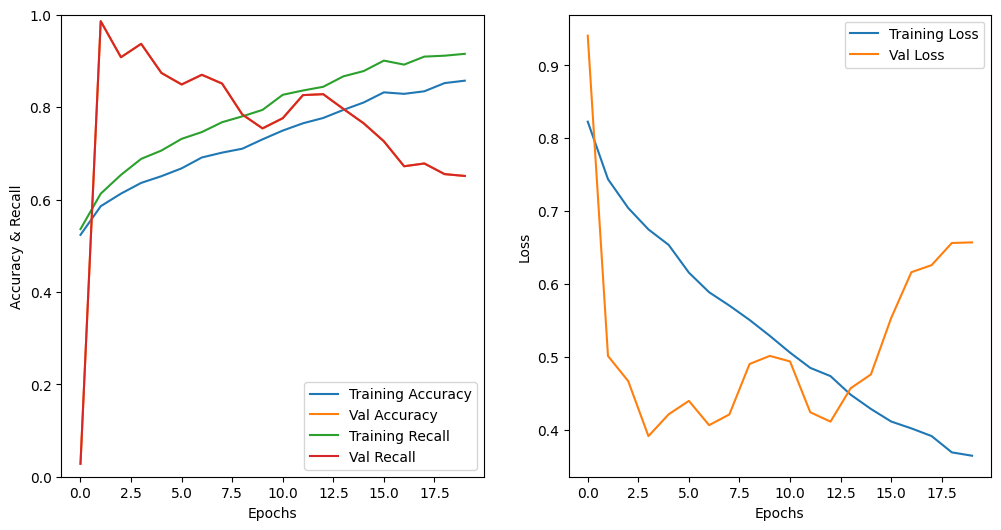

In [13]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Accuracy & Recall' )
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()    

In [14]:
model.evaluate(X_test, y_test)

predictions = model.predict(X_test)

32/32 [==============================] - 3s 56ms/step


# THe TRICk

<Figure size 2000x2000 with 0 Axes>

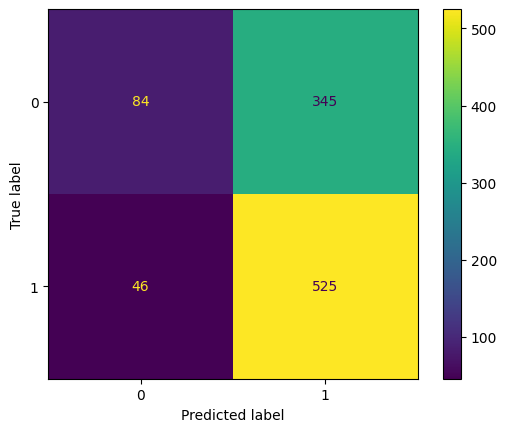

              precision    recall  f1-score   support

           0       0.65      0.20      0.30       429
           1       0.60      0.92      0.73       571

    accuracy                           0.61      1000
   macro avg       0.62      0.56      0.51      1000
weighted avg       0.62      0.61      0.54      1000

Accuracy, Precision , Recall


(0.609, 0.603448275862069, 0.9194395796847635)

In [15]:
# Instead of using 0.5 as threshold for classification , we are going to use only 0.3 as threshold limit to increase recall
preds = [1 if predict >= 0.3 else 0 for predict in predictions]

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(20, 20))  # Adjust the width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()    
print(classification_report(y_test, preds))
print('Accuracy, Precision , Recall')
accuracy_score(y_test, preds), precision_score(y_test, preds), recall_score(y_test, preds)

FInally somthing increased THe REcall tremendously

# GRAD CAMS

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that outputs the feature maps and final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        # If pred_index is not specified, use the predicted class index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use the "jet" colormap to colourize the heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Transform the heatmap into an image.
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    
    # Resize the heatmap to match the image dimensions
    jet_heatmap = jet_heatmap.resize((img.shape[2], img.shape[1]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    
    return superimposed_img[0]

# One image

/tmp/ipykernel_27/3795400255.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


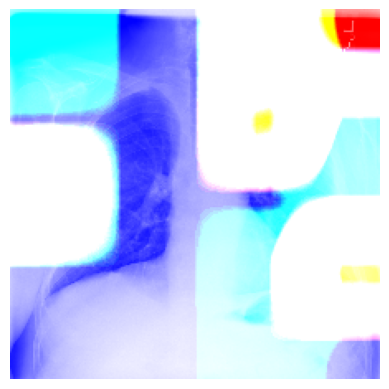

In [17]:
img_array = label_0_images['Image Index'].sample(1)

image = preprocess_image(img_array.values[0])
# Reshape the image to match the expected input shape of the model
image = np.expand_dims(image, axis=0)
# Compute Grad-CAM heatmap for the image
cam = make_gradcam_heatmap(image, model, 'conv2d')
# Overlay heatmap on the original image
superimposed_img = display_gradcam(image, cam, 0.1)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

It's not clear , let's do it instead with multiple images

# Plotting same images with grad cams

/tmp/ipykernel_27/3795400255.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


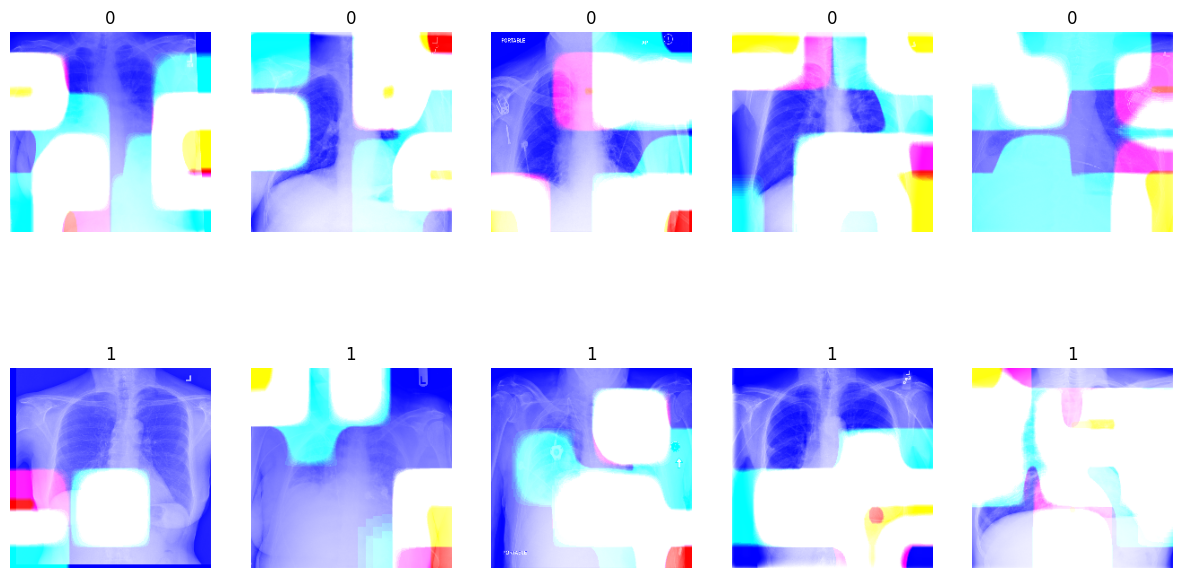

In [18]:
# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Plot images for label '0'
for i, image_file in enumerate(label_0_images['Image Index']):
    
    image = preprocess_image(image_file)
    image = np.expand_dims(image, axis=0)
    # Compute Grad-CAM heatmap for the image
    cam = make_gradcam_heatmap(image, model, 'conv2d') # Logic behind 'conv2d' is that it's last Conventulionalconvolutional neural network of the model
    # Overlay heatmap on the original image
    superimposed_img = display_gradcam(image, cam, 0.1)
    
    axes[0, i].imshow(superimposed_img)
    axes[0, i].set_title('0')
    axes[0, i].axis('off')
    
# Plot images for label '1'
for i, image_file in enumerate(label_1_images['Image Index']):
    
    image = preprocess_image(image_file)
    image = np.expand_dims(image, axis=0)
    # Compute Grad-CAM heatmap for the image
    cam = make_gradcam_heatmap(image, model, 'conv2d') # Logic behind 'conv2d' is that it's last Conventulionalconvolutional neural network of the model
    # Overlay heatmap on the original image
    superimposed_img = display_gradcam(image, cam, 0.1)
    
    axes[1, i].imshow(superimposed_img)
    axes[1, i].set_title('1')
    axes[1, i].axis('off')

*Area highlightened is considered for classfication here, the model is using white area has most significant impact on the results*

# Feel free to experiment with more things to improve it